In [1]:
import tensorflow as tf 
import os
import tarfile 
import pandas as pd
import xlrd
from functools import reduce
import numpy as np
import time
import cv2
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import random
import keras
from glob import glob
import re
import pydot
import scipy.misc

from tensorflow.keras import layers, Input
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import SVG
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import mean_absolute_error
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.python.client import device_lib
from keras.applications.inception_v3 import preprocess_input

%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount=True)

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')
from scripts.utilities import download_images,myCustomGen, CreateCallbacks,MAE
from scripts.patches import *
from scripts.my_models import create_InceptionRes_patches
os.chdir('/content')

In [ ]:
"""
Downloading the images in the Colab Machine:
"""
download_images(train = True, val = False, test = True)

Create the folders used for the patches

In [4]:
if not os.path.exists('./proj'):
        os.mkdir('./proj')
if not os.path.exists('./proj/train_patch'):
        os.mkdir('./proj/train_patch')
if not os.path.exists('./proj/test_patch'):
        os.mkdir('./proj/test_patch')

Import the dataframes

In [5]:
traindf=pd.read_csv('./drive/MyDrive/Colab Notebooks/train_patch.csv',dtype={'id':str, 'boneage':int, 'gender_01':str})
testdf=pd.read_csv('./drive/MyDrive/Colab Notebooks/test_patch.csv',dtype={'id':str,'gender_01':str, 'boneage': int})

Consider only a subset, due to the size of the data

In [ ]:
traindf = train_subset(n=6000)

Use the implemented functions in order to retrieve the patches

In [6]:
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
download_train_patches()
download_test_patches()

Divide the training set in two parts

In [ ]:
my_train, my_val =train_test_split(traindf, test_size=0.2, random_state=123)

This is an example of the patches

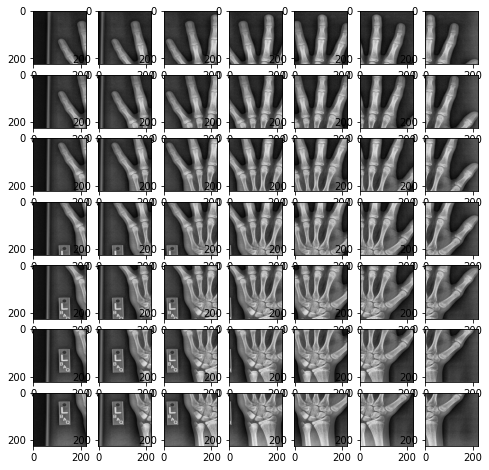

In [7]:
test = pd.read_csv('./drive/MyDrive/Colab Notebooks/test.csv')
test_path= './test-dataset-compress'
test_patch_path = './proj/test_patch'
columns = 7
rows = 7
s=1
imgs=[]
id = test.id[30]
for i in range(49):
  img = cv2.imread(test_patch_path+'/'+str(id)+'_'+'{:02d}'.format(i+1)+'.png')
  imgs.append(img)
fig=plt.figure(figsize=(8, 8))
for i in range(1, columns*rows +1):
    img = imgs[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Import the model

In [ ]:
EMBS=1
IMG_SIZE=224
model = create_InceptionRes_patches(IMG_SIZE, embeddings = EMBS)

In [ ]:
train_data_gen =  ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip = True,preprocessing_function=preprocess_input)
val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

BATCH_SIZE = 32

train_input = myCustomGen(data_gen = train_data_gen, dff =  my_train, train = True, batch_size = BATCH_SIZE, img_size = IMG_SIZE, embeddings = EMBS)
val_input =  myCustomGen(data_gen = val_data_gen, dff =  my_val, train=False,batch_size = BATCH_SIZE, img_size = IMG_SIZE, embeddings = EMBS)

In [ ]:
#create callbacks
my_callbacks = CreateCallbacks(ckp = './drive/MyDrive/Colab Notebooks/Inc_res_v2.h5', training_log = './drive/MyDrive/Colab Notebooks/Inc_res_v2.log',batch_size = BATCH_SIZE, n_samples=len(my_train),max_lr = 0.001,min_lr = 0.00001,epochs_per_step=1)

In [ ]:
#load weights
model.load_weights('./drive/MyDrive/Colab Notebooks/Inc_res_v2.h5')

In [ ]:
#fit model
steps_x_epoch = len(my_train) // BATCH_SIZE # Integer. Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to ceil(num_samples / batch_size)
val_step = len(my_val) // BATCH_SIZE
history = model.fit(train_input,
                           validation_data = val_input,
                           validation_steps = val_step,
                           epochs = 50, #epochs give the number of times the model is trained over the entire dataset.
                           steps_per_epoch = steps_x_epoch,
                           callbacks=my_callbacks)

In [ ]:
#Here, you can load the model with its weights:
model = keras.models.load_model('./drive/MyDrive/Colab Notebooks/model_Inc_res_v2.h5')

## Predictions

In [ ]:
it = 10
model_preds = {}
for k in range(it):
  test_data_gen = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25, horizontal_flip = True,preprocessing_function=preprocess_input)
  test_input =  myCustomGen(data_gen = test_data_gen, dff = testdf, train=False,batch_size = 20, img_size = IMG_SIZE, embeddings = EMBS,test = True)

  new_preds = model.predict(test_input,steps = len(testdf)/20,verbose=1) 
  new_preds = [pred[0] for  pred in new_preds]
  medians=[]
  for i in range(0,9800, 49):
    medians.append(np.median(np.array(new_preds[i:i+49])))
  model_preds[k] = medians

final_preds = []
for i in range(200):
  this_pred = 0
  for j in range(it):
    this_pred += model_preds[j][i]
  final_preds.append(this_pred/it)

In [9]:
final_preds = np.array(final_preds)
bonetruth=np.array(test.boneage.values)
print('Predicions for this model (mean between the iters): {}'.format(MAE(final_preds, bonetruth)))
print('Male redicions for this model (mean between the iters): {}'.format(MAE(final_preds[:100], bonetruth[:100])))
print('Female Predicions for this model (mean between the iters): {}'.format(MAE(final_preds[100:], bonetruth[100:])))

Predicions for this model (mean between the iters): 4.918302467192611
Male redicions for this model (mean between the iters): 4.32818867803776
Female Predicions for this model (mean between the iters): 5.508416256347462


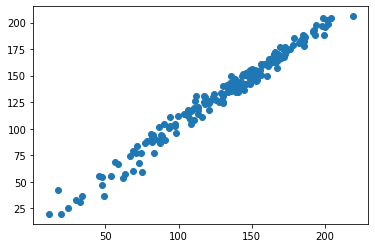

In [10]:
plt.scatter(bonetruth, final_preds)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6071f06e-2e8a-4273-b0c4-308d50da96ab' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>